# Simple Linear Regression

In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-3rd-edition'
                 '/master/ch10/housing.data.txt',
                 header=None,
                 sep=r'\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS',
               'NOX', 'RM', 'AGE', 'DIS', 'RAD',
               'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
               
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


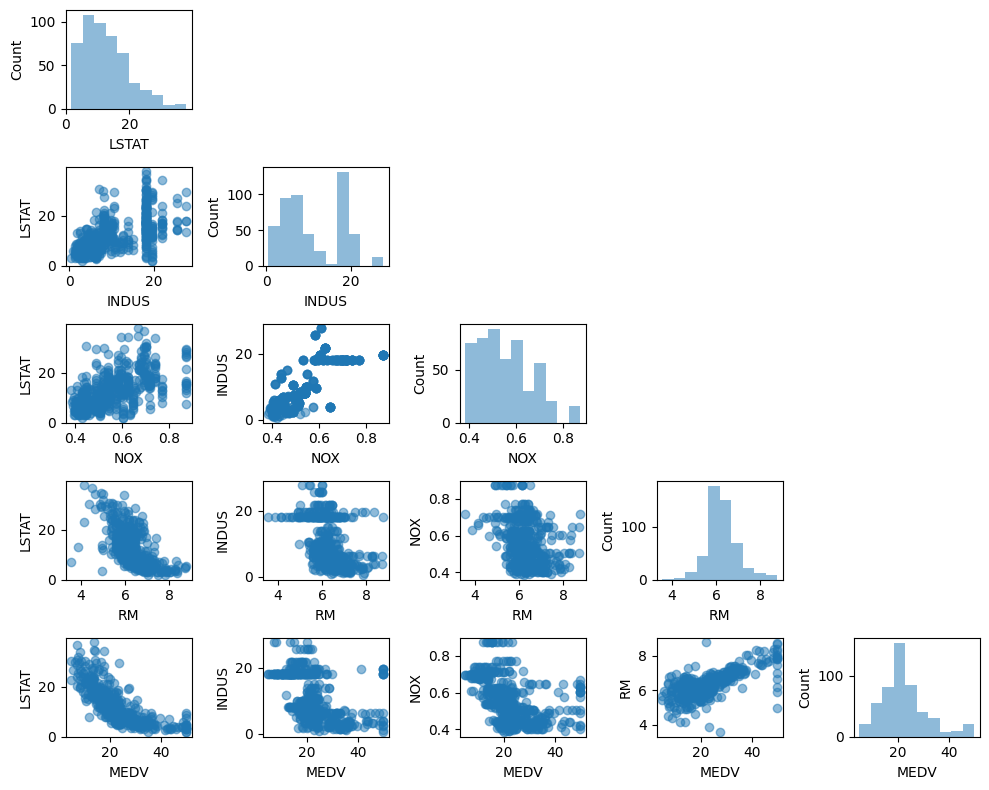

In [3]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
scatterplotmatrix(df[cols].values, figsize=(10, 8),
                  names=cols, alpha=0.5)
plt.tight_layout()
plt.show()

Looking at the scatterplots, we can infer a few things:
1. There seems to be a linear relationship between RM and MEDV
2. RM has a normal distribution
3. MEDV has a normal distribution with some outliers


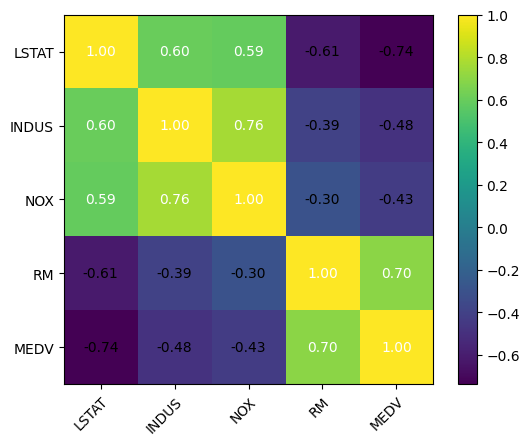

In [5]:
from mlxtend.plotting import heatmap
import numpy as np

cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm,
             row_names=cols,
             column_names=cols)
plt.show()

Linear regression function is the same as the Adaline function, but we remove the unit step function that Adaline uses to return a binary classification.

The cost function we'll be using is ordinary least squares (OLS), which is the same as the sum of squared errors (SSE) cost function we used in Adaline.

$$
J(w) = \frac{1}{2} \sum_{i=1}^{m} (y^{(i)} - \hat{y}^{(i)})^2
$$

- $1/2$ is used to make the math easier when taking the derivative of the cost function during gradient descent as the derivative of $X^2$ is $2X$ which cancels out the $1/2$ in the cost function.
- $\hat{y}^{(i)} = w^T x^{(i)}$ is the prediction for the $i$th training sample.
- $y^{(i)}$ is the true label for the $i$th training sample.
- $m$ is the number of training samples.



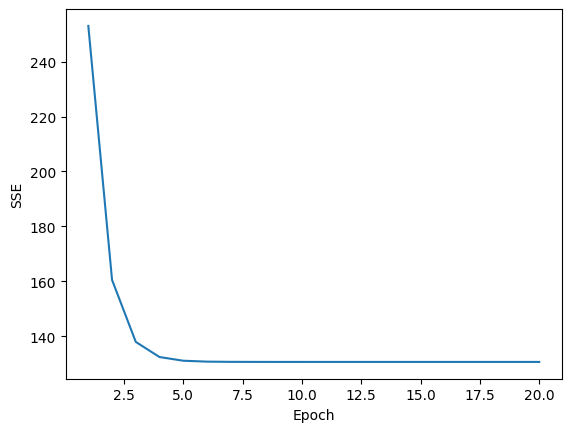

In [6]:
import sys
import os

current_dir = os.path.abspath('')

src_dir = os.path.join(current_dir, '..', '..', 'src')

sys.path.append(src_dir)

from sklearn.preprocessing import StandardScaler
from linearregression.linearRegressionGD import LinearRegressionGD

# We'll be using the RM feature to predict the MEDV feature as it has the highest correlation with MEDV
X = df[['RM']].values
y = df['MEDV'].values

sc_x = StandardScaler()
sc_y = StandardScaler()

# Standardize the features
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

lr = LinearRegressionGD()
lr.fit(X_std, y_std)

plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

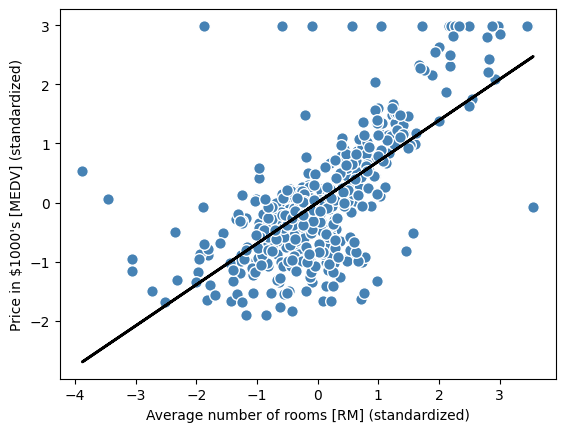

In [7]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.show()

While RM does somewhat predict MEDV, it's not a perfect fit for price predictions.
We can also see that MEDV appears to be clipped at around 3, possibly due to the standardization of the data. This can be fixed by using the inverse of the standardization transformation.

In [13]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
# Reshape price_std to 2D array before inverse transform
price_std = price_std.reshape(-1, 1)
# Extract the scalar value from the array using item()
print("Price in $1000s: %.3f" % sc_y.inverse_transform(price_std).item())

Price in $1000s: 10.840


### Scikit-learn LAPACK linear algebra package

In [15]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)


Slope: 9.102
Intercept: -34.671


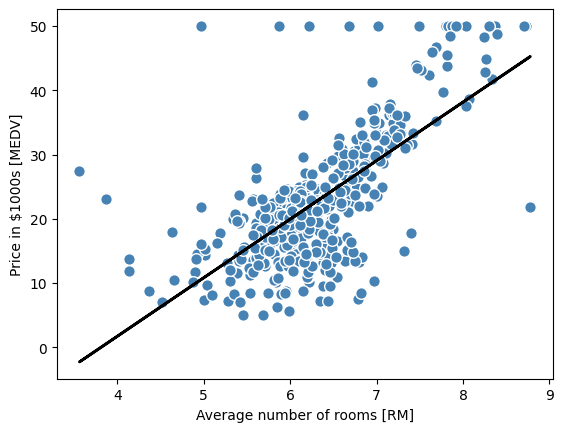

In [16]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

## Evaluating the performance of the model

In [17]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

### Residuals

When working with higher dimensional data, it's often helpful to plot the residuals to see if the model is performing well. The reason being, we can't just visualize the fitted line on the data in dimensions higher than 3.
When looking at the residuals, we want to see if the residuals are randomly distributed around 0. If they are, then the model is performing well. If they are not, then the model is not performing well.
Signs of a good fit:
- The residuals are randomly distributed around 0
- The residuals are normally distributed
- The residuals have constant variance

Signs of a bad fit:
- The residuals are not randomly distributed around 0
- The residuals are not normally distributed
- The residuals have non-constant variance

Seeing patterns in the residuals means that our model was unable to capture some explanatory information in the data, which has leaked into the residuals. You can see this slightly in the plot below, with the straight line of data points in the lower right corner. This can usually be caused by non-linear relationships in the data and can sometimes be improved by adding polynomial features to the model.

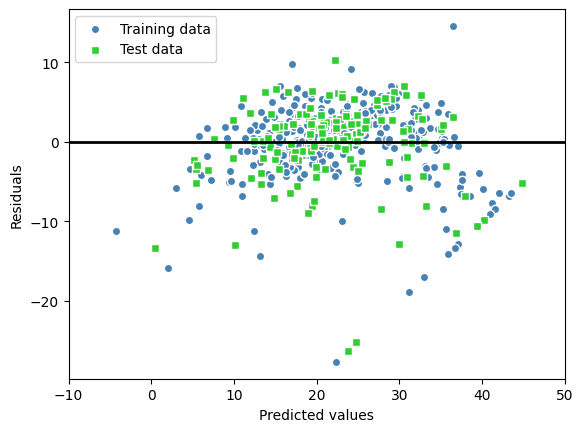

In [18]:
plt.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolor='white', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolor='white', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.show()

### Mean Squared Error (MSE)

The MSE is the average of the squared differences between the predicted values and the true values.

$$
MSE = \frac{1}{m} \sum_{i=1}^{m} (y^{(i)} - \hat{y}^{(i)})^2
$$

- $m$ is the number of training samples.
- $y^{(i)}$ is the true label for the $i$th training sample.
- $\hat{y}^{(i)}$ is the predicted label for the $i$th training sample.

Being the average of the squared differences, that means it's easy to compare the error between different models. A model with a lower MSE is generally better than a model with a higher MSE, as that means on average the model with the lower MSE is predicting closer to the true values.

Below, we can see that the training MSE is 19.96, and it's much lower than the test of 27.19. This shows that there is signs of slight overfitting of the training data.

Note:
- The MSE is unbounded and it is good to keep that in mind when comparing the MSE of different models. For example, say one of the housing prices are scaled down to 1_000, then the MSE will be much lower than a model where house prices are unscaled.
- Somtimes a more useful way to report is the coefficient of determination, or $R^2$, which is the percentage of the variance in the dependent variable that is predictable from the independent variable. A standardized version of MSE.

In [21]:
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


### R-squared

The R-squared is the percentage of the variance in the dependent variable that is predictable from the independent variable. A standardized version of MSE.

$$
R^2 = 1 - \frac{MSE}{Var(y)}
$$

- $MSE$ is the mean squared error.
- $Var(y)$ is the variance of the dependent variable.

The book shows it also as:

$$
R^2 = 1 - \frac{SSE}{SST}
$$

- $SSE$ is the sum of squared errors.
- $SST$ is the total sum of squares.

$$
SST = \sum_{i=1}^{m} (y^{(i)} - \bar{y})^2
$$

- $\bar{y}$ is the mean of the dependent variable.

When looking at the R-squared, if the value is close to 1, then the model is performing well. If the value is close to 0, then the model is performing poorly.

Below, we can see that the R-squared is 0.76, which means that 76% of the variance in the dependent variable is predictable from the independent variable. But the test dataset shows an $R^2$ of 0.67, which means that 67% of the variance in the dependent variable is predictable from the independent variable. This shows that the model is performing better on the training data than the test data, which is a sign of overfitting.

Note:
- The R-squared is bounded between 0 and 1, so it's easy to compare the R-squared of different models.
- The R-squared is also known as the coefficient of determination.

In [22]:
from sklearn.metrics import r2_score

print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

R^2 train: 0.765, test: 0.673


## Regularization

### Ridge Regression (L2)

Ridge regression is a type of regularization technique that adds a penalty term to the cost function to prevent overfitting. The penalty term is the sum of the squares of the coefficients. This is often great for reducing weights to much smaller values, but not 0.

$$
J(w) = \frac{1}{2} \sum_{i=1}^{m} (y^{(i)} - \hat{y}^{(i)})^2 + \frac{\alpha}{2} \sum_{j=1}^{n} w_j^2
$$

- $\alpha$ is the regularization parameter.
- $w_j$ is the weight for the $j$th feature.
- $n$ is the number of features.

### Lasso Regression (L1)

Lasso regression is a type of regularization technique that adds a penalty term to the cost function to prevent overfitting. The penalty term is the sum of the absolute values of the coefficients. This is often great for reducing weights to 0, adding a sparsity to the model. There are some things to keep in mind, for example adding too much sparsity such that $m = n$ will results in the model becoming saturated and not being able to generalize.

$$
J(w) = \frac{1}{2} \sum_{i=1}^{m} (y^{(i)} - \hat{y}^{(i)})^2 + \alpha \sum_{j=1}^{n} |w_j|
$$

- $\alpha$ is the regularization parameter.
- $w_j$ is the weight for the $j$th feature.
- $n$ is the number of features.

### Elastic Net Regression (L1 + L2)

Elastic net regression is a type of regularization technique that adds a penalty term to the cost function to prevent overfitting. The penalty term is a combination of the sum of the squares of the coefficients and the sum of the absolute values of the coefficients. This is often great for reducing weights to much smaller values, but not 0.

$$
J(w) = \frac{1}{2} \sum_{i=1}^{m} (y^{(i)} - \hat{y}^{(i)})^2 + \alpha \beta \sum_{j=1}^{n} |w_j| + \frac{\alpha (1 - \beta)}{2} \sum_{j=1}^{n} w_j^2
$$

- $\alpha$ is the regularization parameter.
- $\beta$ is the mix of L1 and L2 regularization.
- $w_j$ is the weight for the $j$th feature.
- $n$ is the number of features.

## Polynomial Regression

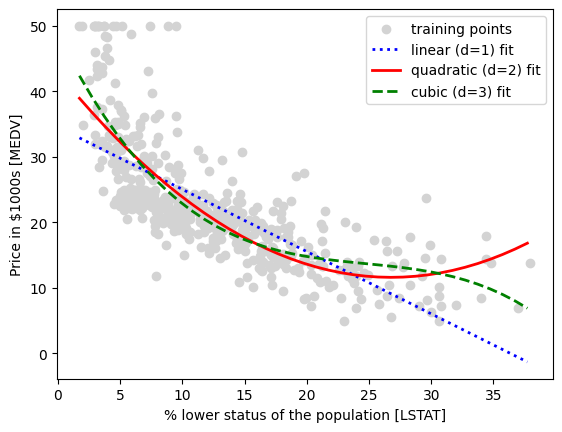

In [25]:


from sklearn.preprocessing import PolynomialFeatures

X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

plt.scatter(X, y, label='training points', color='lightgray')
plt.plot(X_fit, y_lin_fit, label='linear (d=1) fit', color='blue', lw=2, linestyle=':')
plt.plot(X_fit, y_quad_fit, label='quadratic (d=2) fit', color='red', lw=2, linestyle='-')
plt.plot(X_fit, y_cubic_fit, label='cubic (d=3) fit', color='green', lw=2, linestyle='--')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')
plt.show()

Although the cubic model more closely fits the data, adding complexity to the model can lead to overfitting.

Looking at the MEDV-LSTAT plot, we can see that there is possibly a way to make the relationship linear using a log transformation of the LSTAT.

Since the natural log of an exponential creates a straight line, we can assume that:

$$
f(x) = e^{-x}
$$

$$
\log(f(x)) = \log(e^{-x}) = -x
$$

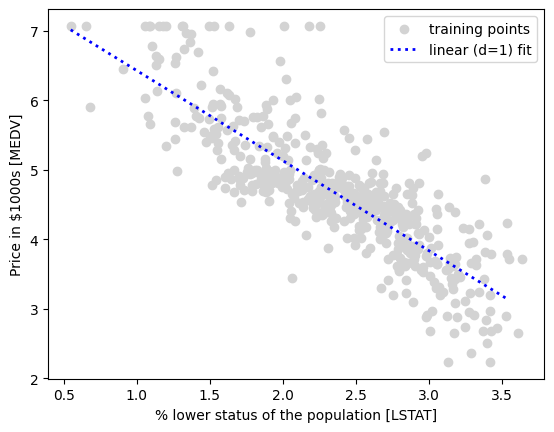

In [26]:
X_log = np.log(X)
y_sqrt = np.sqrt(y)

X_fit = np.arange(X_log.min(), X_log.max(), 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')
plt.plot(X_fit, y_lin_fit, label='linear (d=1) fit', color='blue', lw=2, linestyle=':')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')
plt.show()